# Assimilating sparse data

In this demo, we'll look again at estimating the fluidity coefficient $A$ in Glen's flow law

$$\dot\varepsilon = A\tau^3$$

from observational data for the Larsen Ice Shelf.
The [previous tutorial](https://icepack.github.io/notebooks/tutorials/05-ice-shelf-inverse/) showed how to solve statistical estimation problems when we can assume that the measured data $u^o$ are a continuous field defined throughout our entire domain.
In that setting the model-data misfit functional is

$$E(u) = \int_\Omega\frac{|u - u^o|^2}{2\sigma^2}dx.$$

In this demo, we'll instead focus on *sparse* measurements -- the observations are defined at a set of isolated points $\{x_k\}$, and the model-data misfit functional is

$$E(u) = \sum_k\frac{|u(x_k) - u^o_k|^2}{2\sigma_k^2}.$$

Assembling and differentiating functionals that include pointwise evaluation, alongside the usual continuous operations like taking a gradient or integrating over the whole spatial domain, is relatively uncommon in finite element modeling packages.
Firedrake is the only such package that natively supports defining functionals that involve evaluating a state variable at a discrete point set.
Moreover, the ability to evaluate at a discrete point set composes nicely with the automatic differentiation features, so we can use it in optimization problems just like before.

We'll again use the reparameterization trick of inferring the field $\theta$ in

$$A = A_0e^\theta$$

in order to guarantee that the fluidity coefficient is positive.
We'll also use the same regularization functional as before:

$$R(\theta) = \frac{L^2}{2\Theta^2}\int_\Omega|\nabla \theta|^2dx.$$

In all other respects, the problem will be identical to the previous tutorial.

### Input data

The input data are the same as from the previous demo on inferring the fluidity of the Larsen Ice Shelf.

In [1]:
import subprocess
import geojson
import firedrake
import icepack

outline_filename = icepack.datasets.fetch_outline("larsen-2015")
with open(outline_filename, "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open("larsen.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())
    
command = "gmsh -2 -format msh2 -v 2 -o larsen.msh larsen.geo"
subprocess.run(command.split())
mesh = firedrake.Mesh("larsen.msh")

100%|█████████████████████████████████████| 9.11k/9.11k [00:00<00:00, 10.1MB/s]


The code below is the same boilerplate as in the previous tutorial for plotting simulation results on top of the mosaic of Antarctica image.

In [2]:
import numpy as np
import rasterio
import icepack.plot

coords = np.array(list(geojson.utils.coords(outline)))
δ = 5e3
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
with rasterio.open(image_filename, "r") as image_file:
    image_window = rasterio.windows.from_bounds(
        left=xmin,
        bottom=ymin,
        right=xmax,
        top=ymax,
        transform=image_file.transform,
    )
    image = image_file.read(indexes=1, window=image_window, masked=True)


def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots(*args, **kwargs)
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(
        image_window, image_file.transform
    )
    kw = {
        "extent": (xmin, xmax, ymin, ymax),
        "cmap": "Greys_r",
        "vmin": 12e3,
        "vmax": 16.38e3,
    }
    try:
        axes.imshow(image, **kw)
    except AttributeError:
        for ax in axes:
            ax.imshow(image, **kw)

    return fig, axes

100%|█████████████████████████████████████| 36.6M/36.6M [00:00<00:00, 16.0GB/s]


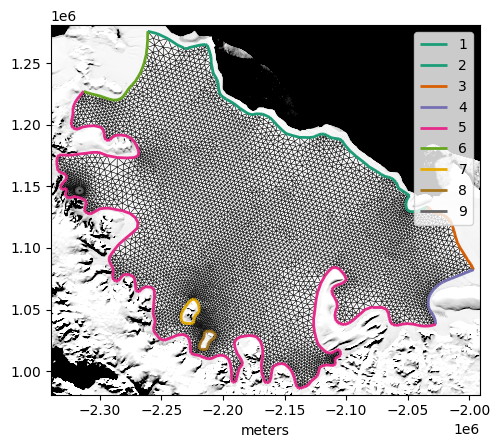

In [3]:
fig, axes = subplots()
axes.set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
firedrake.triplot(mesh, axes=axes, **kwargs)
axes.legend();

Just like in the previous demos, we'll apply a smoothing filter to the thickness, which is necessary to get a reasonable driving stress.

In [4]:
import xarray
from firedrake import assemble, Constant, inner, grad, dx

thickness_filename = icepack.datasets.fetch_bedmachine_antarctica()
thickness = xarray.open_dataset(thickness_filename)["thickness"]

Q = firedrake.FunctionSpace(mesh, family="CG", degree=2)
h0 = icepack.interpolate(thickness, Q)

h = h0.copy(deepcopy=True)
α = Constant(2e3)
J = 0.5 * ((h - h0) ** 2 + α ** 2 * inner(grad(h), grad(h))) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

100%|████████████████████████████████████████| 829M/829M [00:00<00:00, 319GB/s]


### Point data

Before, we were able to just interpolate the gridded data directly from xarray datasets to the finite element spaces we were using for the velocity.
We're going to have to do a bit more work now that we want to work with the point data directly.
Rather than use xarray, we'll read from the NetCDF file using rasterio since it makes certain operations a little easier.

In [5]:
velocity_filename = icepack.datasets.fetch_measures_antarctica()
vx_file = rasterio.open(f"netcdf:{velocity_filename}:VX", "r")
vy_file = rasterio.open(f"netcdf:{velocity_filename}:VY", "r")
stdx_file = rasterio.open(f"netcdf:{velocity_filename}:ERRX", "r")
stdy_file = rasterio.open(f"netcdf:{velocity_filename}:ERRY", "r")

100%|█████████████████████████████████████| 6.97G/6.97G [00:00<00:00, 6.91TB/s]


For starters, we'll want to create window objects around the observational data just like we did for reading the mosaic of Antarctica image.
The windowed transform of the original data will help us to find which points in the raw data are contained inside the mesh.

In [6]:
window = rasterio.windows.from_bounds(
    left=xmin,
    bottom=ymin,
    right=xmax,
    top=ymax,
    transform=vx_file.transform,
).round_lengths().round_offsets()
transform = vx_file.window_transform(window)

Just so you can get an idea of how dense the data are, the plot below zooms in on part of the shelf near the Gipps Ice Rise.
The data points are shown in orange and the mesh triangles in black; in this region, there are about 10-15 data points in each triangle.
In other regions, the mesh is much finer or coarser and so the data density could be different.

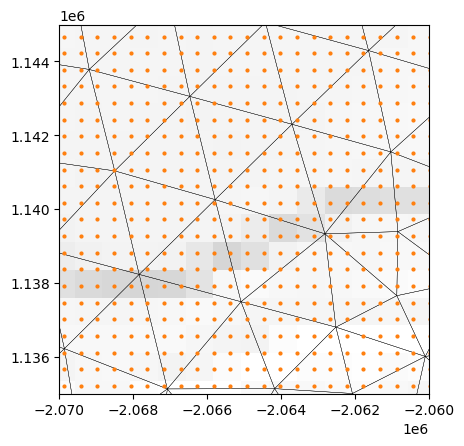

In [7]:
xs = np.array(
    [
        transform * (i, j)
        for i in range(window.width)
        for j in range(window.height)
    ]
)

fig, axes = subplots()
firedrake.triplot(mesh, axes=axes, interior_kw={"linewidth": 0.25})
axes.set_xlim((-2.07e6, -2.06e6))
axes.set_ylim((1.135e6, 1.145e6))
axes.scatter(xs[:, 0], xs[:, 1], 4.0, "tab:orange");

Next we'll use the `locate_cell` method of the mesh to determine which points of the gridded data set are inside the computational domain.

In [8]:
vx = vx_file.read(indexes=1, window=window)
vy = vy_file.read(indexes=1, window=window)
stdx = stdx_file.read(indexes=1, window=window)
stdy = stdy_file.read(indexes=1, window=window)

indices = np.array(
    [
        (i, j)
        for i in range(window.width)
        for j in range(window.height)
        if (
            mesh.locate_cell(transform * (i, j)) and
            stdx[j, i] > 0.0
        )
    ]
)
xs = np.array([transform * idx for idx in indices])

The object that represents this point set from the Firedrake side is called `VertexOnlyMesh`.
To create a vertex-only mesh, we need to supply the background domain and the coordinates of the point cloud.
This step can take some time because there are a lot of points to go through; under the hood, Firedrake is looking through the background mesh to find which triangle each point lives in.

We're also passing an extra argument to make sure that creating the vertex-only mesh will crash in the event that one of the input points is outside of the domain.
This extra flag isn't necessary in our case because we've already made sure that all the points are inside the domain, but it's helpful to know about this flag for debugging later if, say, the sizes of the arrays don't match up.

In [9]:
point_set = firedrake.VertexOnlyMesh(
    mesh, xs, missing_points_behaviour="error"
)

We can create function spaces defined on this point set just like we make function spaces defined on triangular meshes.
We're specifying the element family as "DG" for discontinuous Galerkin, but strictly speaking this doesn't really matter -- on a point cloud, continuous and discontinuous Galerkin representations are the same.

In [10]:
Δ = firedrake.FunctionSpace(point_set, "DG", 0)

u_o = firedrake.Function(Δ)
v_o = firedrake.Function(Δ)
σ_x = firedrake.Function(Δ)
σ_y = firedrake.Function(Δ)

To fill these functions, we'll extract the values at the right indices of the gridded data and stuff them into the raw data array.

In [11]:
u_o.dat.data[:] = vx[indices[:, 1], indices[:, 0]]
v_o.dat.data[:] = vy[indices[:, 1], indices[:, 0]]
σ_x.dat.data[:] = stdx[indices[:, 1], indices[:, 0]]
σ_y.dat.data[:] = stdy[indices[:, 1], indices[:, 0]]

Finally, we'll make an initial guess for the ice velocity by interpolating the gridded data to the triangular mesh.

In [12]:
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
u_initial = icepack.interpolate((vx_file, vy_file), V)

We need to make an initial guess for the fluidity parameter.
In this case, we'll use the same value as in the second demo -- a constant fluidity assuming a temperature of -13C.

In [13]:
T = Constant(260)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [2, 4, 5, 6, 7, 8, 9],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q)
u = solver.diagnostic_solve(
    velocity=u_initial,
    thickness=h,
    log_fluidity=θ,
)

Let's look at the computed of the ice velocity starting from our assumption that the fluidity is constant in space.

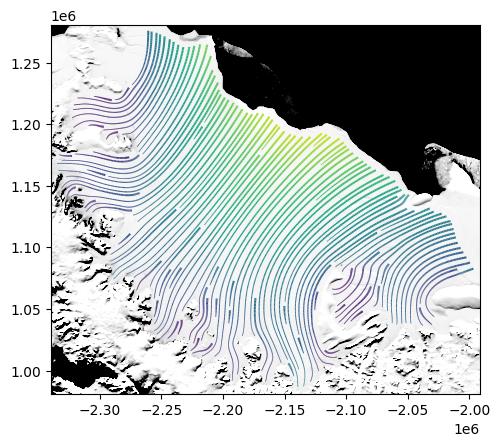

In [14]:
fig, axes = subplots()
kwargs = {"resolution": 2500, "vmin": 0, "vmax": 750}
firedrake.streamplot(u, axes=axes, **kwargs);

Now let's start with a taste of what comes next: interpolating this computed velocity to the vertex only mesh and evaluating the model-data misfit.
The real work is happening here in the two calls to `interpolate` right at the beginning of this cell.
The `interpolate` method can do more than just interpolate an algebraic expression into a finite element space -- it can also interpolate a Function defined on one mesh to a Function defined on a point cloud.

In [15]:
u_interp = firedrake.interpolate(u[0], Δ)
v_interp = firedrake.interpolate(u[1], Δ)

δu, δv = u_interp - u_o, v_interp - v_o

square_error = (δu / σ_x)**2 + (δv / σ_y)**2

N = len(indices)
initial_misfit = assemble(0.5 * square_error * dx) / N
print(initial_misfit)

1966.8973482889858


To sum up expressions over the point cloud, we use the `assemble` function and the measure `dx` just like we do on ordinary triangular meshes!

### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [16]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u_initial, thickness=h, log_fluidity=θ
    )

Since the ice shelf is so large, we're going to want to scale some of our output quantities of interest by the area of the shelf.
This will make everything into nice dimensionless numbers, rather than on the order of $10{}^{10}$.

In [17]:
area = Constant(assemble(Constant(1.0) * dx(mesh)))

The next step is to write a pair of Python functions that will create the model-data misfit functional and the regularization functional.
In the previous demo on inverse problems, we scaled both of these quantities by the area of the domain in order to get nice dimensionless quantities.
Here the loss functional isn't an area integral -- it's a sum over discrete points.
Instead, we'll divide by the number of observations.

In [18]:
def loss_functional(u):
    u_interp = firedrake.interpolate(u[0], Δ)
    v_interp = firedrake.interpolate(u[1], Δ)
    δu, δv = u_interp - u_o, v_interp - v_o
    return 0.5 / Constant(N) * ((δu / σ_x)**2 + (δv / σ_y)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

Now we'll create create a `StatisticsProblem` object.
To specify the problem, we need to give it a procedure for running the simulation, another procedure for evaluating how good our guess is, and an initial guess for the unknown parameters.

In [19]:
from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

Now that we've specified the problem, we'll create a `MaximumProbabilityEstimator` to look for a solution.
The runtime is about the same as in the previous demo, so feel free to put on a fresh pot of coffee.

In [20]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.966897e+03   3.199862e-02                  6.934787e+04   
  1     6.716129e+02   2.012474e-02   6.934787e+04   1.733697e+05   3         2         0         2         3         
  2     6.716129e+02   2.012474e-02   1.733697e+05   1.083561e+04   4         2         2         3         2         
  3     4.842537e+02   1.450778e-02   1.083561e+04   2.708901e+04   5         3         0         1         3         
  4     3.046007e+02   8.790497e-03   2.708901e+04   2.708901e+04   6         4         0         1         3         
  5     1.903613e+02   3.150047e-03   2.708901e+04   6.772253e+04   7         5         0         2         3         
  6     1.303866e+02   6.028879e-03   6.772253e+04   6.772253e+04   8         6         0         4         3         
  7     7.448960e+01   2.335377e-03   6.772253e+04   6.772253e+0

As before, the algorithm reduces the objective by two orders of magnitude by the time it's converged.
The computed log-fluidity field looks very similar to the one obtained when we matched the computed velocity to the field obtained by interpolating the observations to the mesh.

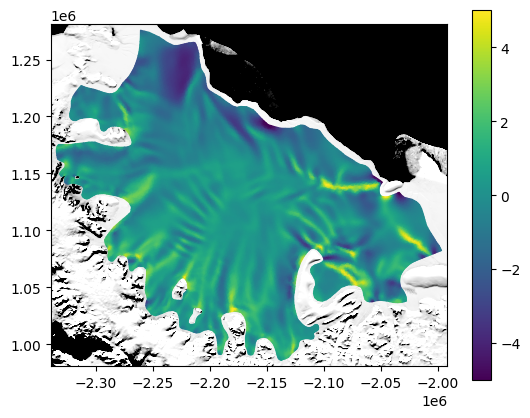

In [21]:
fig, axes = subplots()
colors = firedrake.tripcolor(θ, vmin=-5, vmax=+5, axes=axes)
fig.colorbar(colors);

### Conclusion

The results we obtained from assimilating the point data directly were mostly similar to those we obtained from interpolating them to the finite element mesh.
Why go through the exercise at all?

One of the advantages of assimilating sparse point data directly is that we can be more rigorous about the statistical interpretation of our results.
If we assume that the observational data are normally distributed about the true velocity values with mean 0 and with standard deviation as reported in the remote sensing product, then the sum of squared errors is a $\chi^2$ random variable with $N - M$ degrees of freedom, where $N$ is the number of observation points and $M$ is the number of degrees of freedom of the parameters we're fitting.

In [22]:
u = simulation(θ)
χ_2 = assemble(loss_functional(u))
print(χ_2)

17.59851067499076


By using the point data directly, we know exactly what $N$ is, which isn't true at all when we're comparing to a velocity that's been interpolated to a mesh that could have a more or less arbitrary and variable resolution.
We still have the problem of determining the number $M$ of degrees of freedom, which is a little more involved because of the regularization; we have to read it off from the trace of the posterior covariance matrix.
That's outside the scope of this tutorial, but we could also have, for example, used a few eigenfunctions of the Laplace operator as a fixed set of basis functions with no regularization instead.
In any case, using the raw data gets us closer to a statistical exactitude.
If we can't fit our model to observations as well as we expect, that suggests either that we've mis-characterized the statistical properties of the observations or that our model is incorrect.

The second key advantage was not apparent in this notebook but does show up in other applications.
Here we used a gridded data product with fairly dense coverage over the domain of interest.
Other data sources are genuinely sparse, for example laser altimetry measurements from ICESat-2, radar sounding from Operation IceBridge flights, or even strain gauge or thermometry data from isolated boreholes.